In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

This notebook includes a Kalman Bucy filter adapted to the conditionally-gaussian Lorenz-63 equations.

# Set Up

Get a "true" x using Euler Maruyama in order to have a conditionally-gaussian system

In [2]:
def EM(x0, T = 100, timesteps = 100000, c = 1e-6):
    delta_t = T/timesteps
    rho = 28
    beta = 8/3
    sigma = 10
    final = np.zeros((timesteps,3))
    final[0] = x0
    for i in range(timesteps-1):
        final[i+1, 0] = final[i,0] + delta_t*(sigma*(final[i,1]-final[i,0]))
        final[i+1, 1] = final[i,1] + delta_t*(final[i,0]*(rho - final[i,2])-final[i,1]) + c*np.random.normal(0,np.sqrt(delta_t))
        final[i+1, 2] = final[i,2] + delta_t*(final[i,0]*final[i,1]-beta*final[i,2])

    return final


In [3]:
sol = EM([0,1,0])
x = sol[:,0]
y = sol[:,1]
z = sol[:,2]

Plot the system to get a feel for what the system should look like.

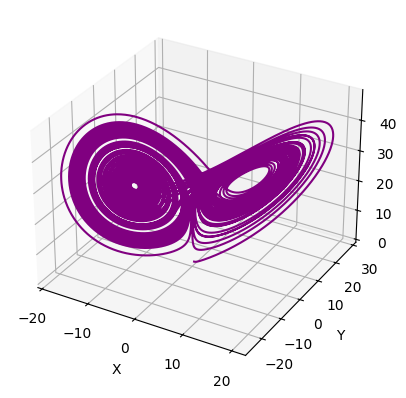

In [4]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,y,z, 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.show()

# Implementation

Implement the Kalman Bucy filter for Lorenz-63

In [5]:
def lorenz_kb(x):
    rho = 28
    beta = 8/3
    sigma = 10
    T = 100
    n = 100000
    dt = T/n

    Sigma1 = np.array([[1]])

    x_vals = x.copy()

    Sigma2 = np.diag([.1,0])   

    # random starting point
    u0 = 2*np.random.randn(2)
    u_hat = np.zeros((2,n))
    u_hat[:,0] = u0

    R = np.eye(2)
    Sig_inv = np.linalg.inv(Sigma1@Sigma1.T)


    for i in range(1, n): 
        A0 = -sigma*x[i]
        A1 = np.array([[sigma,0]])

        a1 = np.array([[-1,-x_vals[i]],[x_vals[i],-beta]])
        a0 = np.array([rho*x_vals[i],0])

        duI = x_vals[i] - x_vals[i-1]

        innovation = duI - (A0 + (A1 @ u_hat[:,i-1])) * dt
        u_hat[:,i] = u_hat[:,i-1] + dt*(a1@u_hat[:,i-1] + a0) + ((R @ A1.T) @ Sig_inv * innovation).flatten()
        R += (a1@R + R@ a1.T  + Sigma2@Sigma2.T - R@A1.T@Sig_inv@A1@R)*dt

        if np.isnan(R).any():
            print(f"NaN detected at step {i}")
            break
    return u_hat






In [6]:
# the first row of u_hat is y
# the second row of u_hat is z

u_hat = lorenz_kb(x)


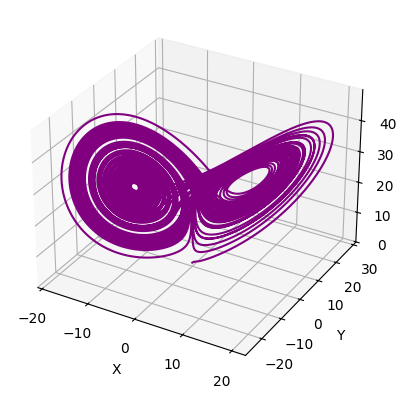

In [7]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,u_hat[0],u_hat[1], 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.show()

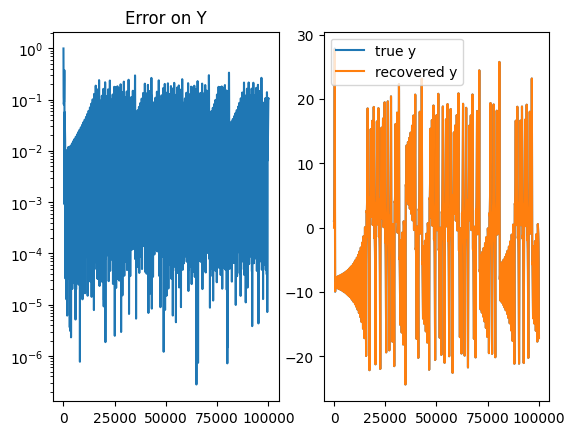

In [8]:
plt.subplot(121)
plt.semilogy(abs(y - u_hat[0]))
plt.title("Error on Y")
plt.subplot(122)
plt.plot(y, label = 'true y')
plt.plot(u_hat[0], label = 'recovered y')
plt.legend()
plt.show()

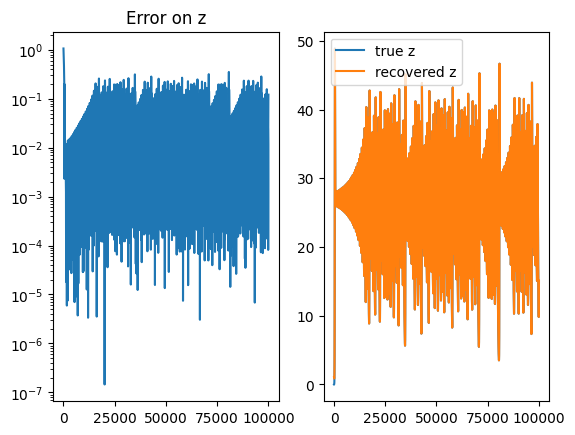

In [9]:
plt.subplot(121)
plt.semilogy(abs(z - u_hat[1]))
plt.title("Error on z")
plt.subplot(122)
plt.plot(z, label = 'true z')
plt.plot(u_hat[1], label = 'recovered z')
plt.legend()
plt.show()

## Add noise to observations

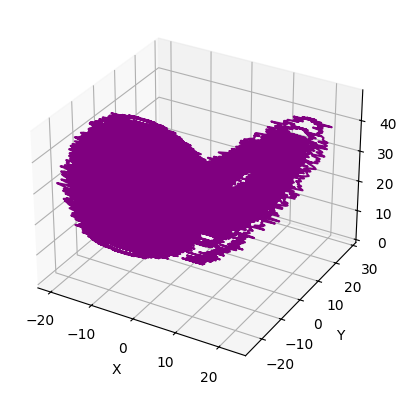

In [10]:
sol = EM([0,1,0])
x = sol[:,0]
y = sol[:,1]
z = sol[:,2]

# add noise to observations
x = sol[:,0] + np.random.randn(len(x))

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,y,z, 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
"true system with noise"
plt.show()

u_hat = lorenz_kb(x)

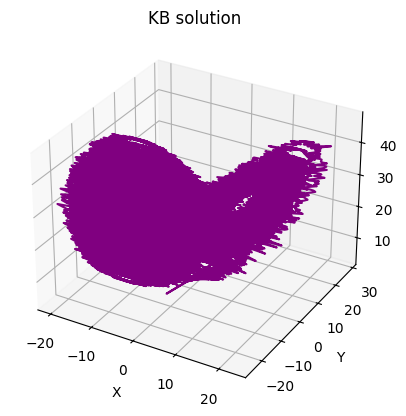

In [11]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,u_hat[0],u_hat[1], 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.title("KB solution")
plt.show()

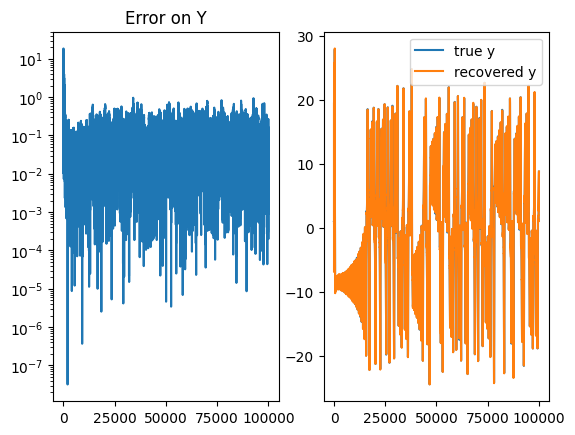

In [12]:
plt.subplot(121)
plt.semilogy(abs(y - u_hat[0]))
plt.title("Error on Y")
plt.subplot(122)
plt.plot(y, label = 'true y')
plt.plot(u_hat[0], label = 'recovered y')
plt.legend()
plt.show()

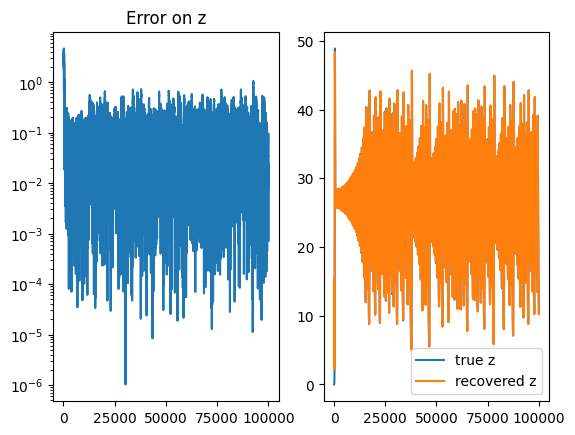

In [13]:
plt.subplot(121)
plt.semilogy(abs(z - u_hat[1]))
plt.title("Error on z")
plt.subplot(122)
plt.plot(z, label = 'true z')
plt.plot(u_hat[1], label = 'recovered z')
plt.legend()
plt.show()